In [1]:
%reload_ext autoreload
%autoreload 2

In [23]:
import os
import random
import logging
import multiprocessing
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import (Dataset, DataLoader)

from ctorch.config import ComplexTorchConfig
from ctorch.data_access import DataClass
from ctorch.model import UNet
from ctorch.evaluation import CustomEvaluation
from ctorch.utils import timing
from ctorch.utils.constants import (
    PROCESSED_DIR,
    TRAIN,
    VAL,
    TEST,
    INPUT,
    TARGET,
    HEIGHT,
    WIDTH,
    IN_CHANNELS,
    OUT_CHANNELS,
    HIDDEN_DIMENSIONS,
    PARAMETERS,
    CHECKPOINTS_DIR,
    ARTEFACTS,
    EPOCH,
    TRAIN_LOSS,
    VALID_LOSS,
    TRAIN_PSNR,
    TRAIN_PCC,
    TRAIN_SSIM,
    TRAIN_SCC,
    VALID_PSNR,
    VALID_PCC,
    VALID_SSIM,
    VALID_SCC,
    BEST_MODEL
)

PARENT_PATH = Path(os.getcwd()).parent.absolute()
device = "cuda" if torch.cuda.is_available() else "cpu"

FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)
logger = logging.getLogger(__name__)

# Seed everything
seed = 128
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

Initialize data class for accessing data

In [3]:
config = ComplexTorchConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)

Initialize custom evaluation class for computing evaluation metrics

In [4]:
eval = CustomEvaluation()

#### Define torch model and custom dataset

Define Complex-UNet model

In [5]:
class Model(nn.Module):
    def __init__(self, config: ComplexTorchConfig):
        super().__init__()
        self.config = config
        self.params = self.config.MODEL_PARAMETERS
        H_difference = self.config.PREPROCESSING_NEW_HEIGHT - HEIGHT
        W_difference = self.config.PREPROCESSING_NEW_WIDTH - WIDTH
        self.pad = (
            round(W_difference / 2),
            W_difference - round(W_difference / 2),
            round(H_difference / 2),
            H_difference - round(H_difference / 2)
        )
        self.unet = UNet(
            in_channels=self.params[IN_CHANNELS],
            out_channels=self.params[OUT_CHANNELS],
            hidden_dims=self.params[HIDDEN_DIMENSIONS],
            pad=self.pad,
            **self.params[PARAMETERS]
        )

    def forward(self, x: torch.Tensor):
        return self.unet(x)

Define custom dataset for training model

In [6]:
class KSpaceDataset(Dataset):
    def __init__(self, input_path: Path, target_path: Path):
        super().__init__()
        self.input_path = input_path
        self.target_path = target_path
        self.files = sorted(os.listdir(self.input_path))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file = self.files[idx]
        X = np.load(os.path.join(self.input_path, file))
        Y = np.load(os.path.join(self.target_path, file))
        X = torch.from_numpy(X)
        Y = torch.from_numpy(Y)
        return X, Y

#### Utility functions

Define utility function to create data loaders

In [7]:
def make_data_loader(
    input_path: Path,
    target_path: Path,
    batch_size: int,
    shuffle: bool = True,
    num_workers: int = 0
    ) -> DataLoader:
    data = KSpaceDataset(input_path=input_path, target_path=target_path)
    data_loader = DataLoader(
        dataset=data,
        batch_size = batch_size,
        shuffle = shuffle,
        num_workers=num_workers
    )
    return data_loader

Define utility function to train model and save artefacts

In [8]:
@timing
def train(
    model: Model,
    train_loader: DataLoader,
    valid_loader: DataLoader,
    epochs: int,
    criterion,
    optimizer,
    scheduler,
    checkpoint_path: Path,
    append_artefacts_path: Path = None
):
    lo = 0
    hi = epochs
    if append_artefacts_path is not None:
        if os.path.isfile(append_artefacts_path):
            artefacts = np.load(append_artefacts_path)
            lo = artefacts.shape[0]
            hi = lo + epochs
            logger.info(f"Resuming training for {epochs} epochs")
        else:
            raise FileNotFoundError("Supplied artefacts don't exist")
    else:
        logger.info(f"Training for {epochs} epochs")
    # Move model to device
    model.to(device)
    # Lists to keep the losses and evaluation scores at the end of each epoch
    train_loss, valid_loss = list(), list()
    train_eval, valid_eval = list(), list()
    for epoch in range(lo, hi):
        # Dummy lists to keep the losses and evaluation scores at the end of each iteration
        # (one batch forward and backward process)
        train_batch_loss, valid_batch_loss = list(), list()
        train_batch_eval, valid_batch_eval = list(), list()
        # Training mode
        model.train()
        for i, (input, ground_truth) in enumerate(train_loader):
            # Move input to device
            input = input.to(device)
            ground_truth = ground_truth.to(device)
            # Forward pass
            residual = model(input)
            # Get prediction
            output = input + residual
            # Calculate loss
            loss = criterion(torch.view_as_real(residual), torch.view_as_real(ground_truth - input))
            # Reset gradients
            optimizer.zero_grad()
            # Backward pass (backpropogation)
            loss.backward()
            # Update weights
            optimizer.step()
            # Collect loss and evaluation scores
            train_batch_loss.append(loss.item())
            train_batch_eval.append(eval.compute_scores(
                output.detach().cpu().numpy(),
                ground_truth.detach().cpu().numpy()
            ))
            message = \
                f"EPOCH:{epoch+1}/{hi}, " + \
                f"step:{i+1}/{len(train_loader)}, " + \
                f"loss={loss.item()}"
            print("\r", message, end="")
        # Take the average of iteration losses and evaluation scores
        # and append to respective lists
        train_loss.append(np.mean(train_batch_loss))
        train_eval.append(np.mean(train_batch_eval, axis=0).tolist())
        # Evaluation mode
        model.eval()
        with torch.no_grad():
            for i, (input, ground_truth) in enumerate(valid_loader):
                # Move input to device
                input = input.to(device)
                ground_truth = ground_truth.to(device)
                # Forward pass
                residual = model(input)
                # Get prediction
                output = input + residual
                # Calculate loss
                loss = criterion(torch.view_as_real(residual), torch.view_as_real(ground_truth - input))
                valid_batch_loss.append(loss.item())
                valid_batch_eval.append(eval.compute_scores(
                    output.detach().cpu().numpy(),
                    ground_truth.detach().cpu().numpy()
                ))
                message = \
                    f"EPOCH:{epoch+1}/{hi}, " + \
                    f"step:{i+1}/{len(valid_loader)}, " + \
                    f"loss={loss.item()}"
                print("\r", message, end="")
        # Take the average of iteration losses and evaluation scores
        # and append to respective lists
        valid_loss.append(np.mean(valid_batch_loss))
        valid_eval.append(np.mean(valid_batch_eval, axis=0).tolist())
        # Adjust learning rate
        scheduler.step(valid_loss[-1])
        message = \
            f"EPOCH:{epoch+1}/{hi} - " + \
            f"Training Loss: {train_loss[-1]}, " + \
            f"Validation Loss: {valid_loss[-1]}"
        print("\r", message)
        # Save model
        state = f"epoch_{epoch+1:03}.pt"
        save_path = os.path.join(checkpoint_path, state)
        torch.save({
            "epoch": epoch+1,
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict()
        }, save_path)
    # Save artefacts
    new_artefacts = np.hstack([
        np.array(range(lo + 1, hi + 1)).reshape(-1, 1),
        np.array(train_loss).reshape(-1, 1),
        np.array(valid_loss).reshape(-1, 1),
        np.array(train_eval).reshape(-1, 4),
        np.array(valid_eval).reshape(-1, 4)
    ])
    if append_artefacts_path is not None:
        new_artefacts = np.vstack([artefacts, new_artefacts])
    else:
        append_artefacts_path = os.path.join(data.reports_path, ARTEFACTS)
    np.save(append_artefacts_path, new_artefacts)
    return

#### Build data loaders, initialize model and set hyper-parameters

Build data loaders for train and validation datasets

In [9]:
BATCH_SIZE = 16
NUM_WORKERS = max(0, multiprocessing.cpu_count() - 2)

train_input_path = os.path.join(data.data_path, PROCESSED_DIR, TRAIN, INPUT)
train_target_path = os.path.join(data.data_path, PROCESSED_DIR, TRAIN, TARGET)
train_loader = make_data_loader(
    input_path=train_input_path,
    target_path=train_target_path,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

valid_input_path = os.path.join(data.data_path, PROCESSED_DIR, VAL, INPUT)
valid_target_path = os.path.join(data.data_path, PROCESSED_DIR, VAL, TARGET)
valid_loader = make_data_loader(
    input_path=valid_input_path,
    target_path=valid_target_path,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

logger.info(f"Number of training samples: {len(train_loader.dataset)}")
logger.info(f"Number of validation samples: {len(valid_loader.dataset)}")

2023-01-05 03:44:21,404 - __main__ - INFO - Number of training samples: 7056
2023-01-05 03:44:21,405 - __main__ - INFO - Number of validation samples: 756


Set the checkpoints path

In [10]:
checkpoint_path = Path(os.path.join(data.current_path, CHECKPOINTS_DIR))
checkpoint_path.mkdir(parents=True, exist_ok=True)
logger.info(f"Trained models for each epoch will be saved to {checkpoint_path}")

2023-01-05 03:44:21,516 - __main__ - INFO - Trained models for each epoch will be saved to /home/vtyagi/repos/MRI-Denoising/checkpoints


Initialize UNet model and set criterion, optimizer and scheduler

- Loss: Mean Squared Error (pixel-wise)
- Optimizer: Adam
- Scheduler: Reduce learning rate when validation loss has stopped improving

In [11]:
LEARNING_RATE = 1e-03
FACTOR = 0.1
PATIENCE = 2
VERBOSE = True

model = Model(config)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=FACTOR,
    patience=PATIENCE,
    verbose=VERBOSE
)

Number of trainable parameters

In [12]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
logger.info(f"Total trainable parameters: {pytorch_total_params:,}")

2023-01-05 03:44:21,819 - __main__ - INFO - Total trainable parameters: 1,925,988


#### Train model

In [13]:
EPOCHS = 50
train(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    checkpoint_path=checkpoint_path
)

2023-01-05 03:44:21,933 - __main__ - INFO - Training for 50 epochs


 EPOCH:1/50 - Training Loss: 0.00024922958306296283, Validation Loss: 3.943301012535964e-06
 EPOCH:2/50 - Training Loss: 3.9642634032888906e-06, Validation Loss: 3.89470357238982e-06
 EPOCH:3/50 - Training Loss: 3.9140171287615474e-06, Validation Loss: 3.842177273819895e-06
 EPOCH:4/50 - Training Loss: 3.920526397809734e-06, Validation Loss: 3.776191042229963e-06
 EPOCH:5/50 - Training Loss: 4.106969812506132e-06, Validation Loss: 3.731442323129386e-06
 EPOCH:6/50 - Training Loss: 3.982648992845613e-06, Validation Loss: 3.5780686703882716e-06
 EPOCH:7/50 - Training Loss: 3.813970381373042e-06, Validation Loss: 3.700552946147203e-06
 EPOCH:8/50 - Training Loss: 3.846660742573623e-06, Validation Loss: 3.350804593793555e-06
 EPOCH:9/50 - Training Loss: 3.7387532296419677e-06, Validation Loss: 3.843799175247871e-06
 EPOCH:10/50 - Training Loss: 3.751256835967647e-06, Validation Loss: 3.090160177521284e-06
 EPOCH:11/50 - Training Loss: 3.544714097761594e-06, Validation Loss: 3.4837369398132

2023-01-05 14:11:37,196 - ctorch.utils.utils - INFO - func:train took: 10 hr and 27 min


 EPOCH:50/50 - Training Loss: 2.366459336862756e-06, Validation Loss: 2.2880631291855025e-06


##### Check if we need to continue training

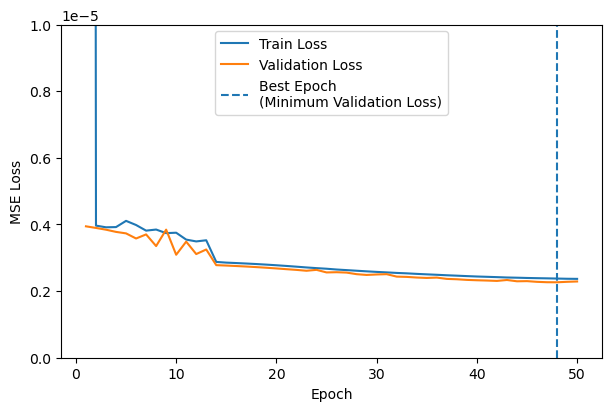

In [14]:
artefacts = np.load(os.path.join(data.reports_path, ARTEFACTS))

fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
sns.lineplot(
    x=artefacts[:, EPOCH].reshape(-1,),
    y=artefacts[:, TRAIN_LOSS].reshape(-1,),
    ax=ax,
    label="Train Loss"
)
sns.lineplot(
    x=artefacts[:, EPOCH].reshape(-1,),
    y=artefacts[:, VALID_LOSS].reshape(-1,),
    ax=ax, label="Validation Loss"
)
plt.axvline(x=np.argmin(artefacts[:, VALID_LOSS]) + 1, linestyle="dashed", label="Best Epoch\n(Minimum Validation Loss)")
ax.set_ylim(0, 1e-05)
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE Loss")
plt.legend(loc="upper center");

As the validation loss is still decreasing, we should continue training

##### Resume training

Load model, optimizer and scheduler at last epoch

In [15]:
latest_epoch = np.max(artefacts[:, EPOCH]).astype(int)
state = f"epoch_{latest_epoch:03}.pt"
checkpoint = torch.load(os.path.join(checkpoint_path, state), map_location="cpu")
model.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])
scheduler.load_state_dict(checkpoint["scheduler"])

Continue training

In [16]:
EPOCHS = 50
train(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    checkpoint_path=checkpoint_path,
    append_artefacts_path=os.path.join(data.reports_path, ARTEFACTS)
)

2023-01-05 14:13:40,206 - __main__ - INFO - Resuming training for 50 epochs


 EPOCH:51/100 - Training Loss: 2.361621637098165e-06, Validation Loss: 2.2522349389930696e-06
 EPOCH:52/100 - Training Loss: 2.359246743290729e-06, Validation Loss: 2.3023242595362112e-06
 EPOCH:53/100 - Training Loss: 2.35167939806208e-06, Validation Loss: 2.248826746154009e-06
 EPOCH:54/100 - Training Loss: 2.3503610656417775e-06, Validation Loss: 2.269617078572613e-06
 EPOCH:55/100 - Training Loss: 2.3463281292220892e-06, Validation Loss: 2.23826102422701e-06
 EPOCH:56/100 - Training Loss: 2.3427680973075763e-06, Validation Loss: 2.2331470361791617e-06
 EPOCH:57/100 - Training Loss: 2.3401955760760145e-06, Validation Loss: 2.2324635722270614e-06
 EPOCH:58/100 - Training Loss: 2.3380550960207822e-06, Validation Loss: 2.2299803627371753e-06
 EPOCH:59/100 - Training Loss: 2.3346102162410104e-06, Validation Loss: 2.2248303371460074e-06
 EPOCH:60/100 - Training Loss: 2.3333836040928007e-06, Validation Loss: 2.245511855865819e-06
 EPOCH:61/100 - Training Loss: 2.329374087161683e-06, Valid

2023-01-06 00:38:54,565 - ctorch.utils.utils - INFO - func:train took: 10 hr and 25 min


 EPOCH:100/100 - Training Loss: 2.279025566146924e-06, Validation Loss: 2.1785962651676982e-06


##### Check if we need to continue training

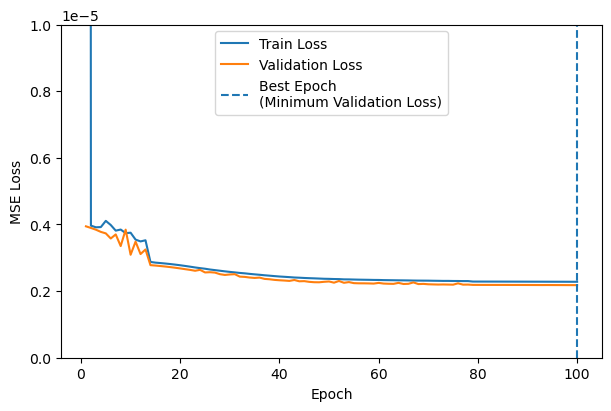

In [17]:
artefacts = np.load(os.path.join(data.reports_path, ARTEFACTS))

fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
sns.lineplot(
    x=artefacts[:, EPOCH].reshape(-1,),
    y=artefacts[:, TRAIN_LOSS].reshape(-1,),
    ax=ax,
    label="Train Loss"
)
sns.lineplot(
    x=artefacts[:, EPOCH].reshape(-1,),
    y=artefacts[:, VALID_LOSS].reshape(-1,),
    ax=ax, label="Validation Loss"
)
plt.axvline(x=np.argmin(artefacts[:, VALID_LOSS]) + 1, linestyle="dashed", label="Best Epoch\n(Minimum Validation Loss)")
ax.set_ylim(0, 1e-05)
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE Loss")
plt.legend(loc="upper center");

Again, the validation loss is still decreasing and we'll resume training.

##### Resume training

Load model, optimizer and scheduler at last epoch

In [18]:
latest_epoch = np.max(artefacts[:, EPOCH]).astype(int)
state = f"epoch_{latest_epoch:03}.pt"
checkpoint = torch.load(os.path.join(checkpoint_path, state), map_location="cpu")
model.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])
scheduler.load_state_dict(checkpoint["scheduler"])

Continue training

In [19]:
EPOCHS = 50
train(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    checkpoint_path=checkpoint_path,
    append_artefacts_path=os.path.join(data.reports_path, ARTEFACTS)
)

2023-01-06 00:41:41,056 - __main__ - INFO - Resuming training for 50 epochs


 EPOCH:101/150 - Training Loss: 2.278681433511208e-06, Validation Loss: 2.1785510249117124e-06
 EPOCH:102/150 - Training Loss: 2.2783544157715377e-06, Validation Loss: 2.178221753486772e-06
 EPOCH:103/150 - Training Loss: 2.2779166977293273e-06, Validation Loss: 2.1786122547477285e-06
 EPOCH:104/150 - Training Loss: 2.277646514385753e-06, Validation Loss: 2.1773966771831965e-06
 EPOCH:105/150 - Training Loss: 2.2773541208618984e-06, Validation Loss: 2.177345237441841e-06
 EPOCH:106/150 - Training Loss: 2.2769871913083892e-06, Validation Loss: 2.176559538232444e-06
 EPOCH:107/150 - Training Loss: 2.2766720516520185e-06, Validation Loss: 2.1769635919118477e-06
 EPOCH:108/150 - Training Loss: 2.276361968095303e-06, Validation Loss: 2.1762349232308984e-06
 EPOCH:109/150 - Training Loss: 2.2761367774133788e-06, Validation Loss: 2.175709089632013e-06
 EPOCH:110/150 - Training Loss: 2.2757183237476067e-06, Validation Loss: 2.1752457458982613e-06
 EPOCH:111/150 - Training Loss: 2.2755086754227

2023-01-06 11:12:29,598 - ctorch.utils.utils - INFO - func:train took: 10 hr and 30 min


 EPOCH:150/150 - Training Loss: 2.273578200736071e-06, Validation Loss: 2.173971735667616e-06


##### Check if we need to continue training

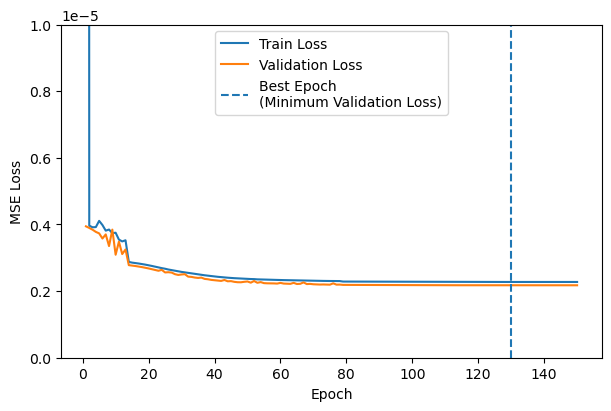

In [20]:
artefacts = np.load(os.path.join(data.reports_path, ARTEFACTS))

fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
sns.lineplot(
    x=artefacts[:, EPOCH].reshape(-1,),
    y=artefacts[:, TRAIN_LOSS].reshape(-1,),
    ax=ax,
    label="Train Loss"
)
sns.lineplot(
    x=artefacts[:, EPOCH].reshape(-1,),
    y=artefacts[:, VALID_LOSS].reshape(-1,),
    ax=ax, label="Validation Loss"
)
plt.axvline(x=np.argmin(artefacts[:, VALID_LOSS]) + 1, linestyle="dashed", label="Best Epoch\n(Minimum Validation Loss)")
ax.set_ylim(0, 1e-05)
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE Loss")
plt.legend(loc="upper center");

#### Save the best model for inference

In [22]:
best_epoch = np.argmin(artefacts[:, VALID_LOSS]) + 1
logger.info(f"Best epoch: {best_epoch}")

2023-01-06 13:29:01,329 - __main__ - INFO - Best epoch: 130


In [26]:
state = f"epoch_{best_epoch:03}.pt"
checkpoint = torch.load(os.path.join(checkpoint_path, state), map_location="cpu")
model.load_state_dict(checkpoint["model"])

save_path = os.path.join(checkpoint_path, BEST_MODEL)
torch.save({
    "epoch": best_epoch,
    "model": model.state_dict()
}, save_path)
logger.info(f"Saved best model to {save_path}")

2023-01-06 13:32:52,403 - __main__ - INFO - Saved best model to /home/vtyagi/repos/MRI-Denoising/checkpoints/best_model.pt
